In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat 

import torch
import torch.nn as nn

In [15]:
from kspace_handling_functions import ifftnd,fftnd,rms_comb,do_image,plot_pair
from plotting_functions import *
from kspace_handling_functions import normalize_image,normalize_kspace_max,normalize_kspace_z,norm_dataset
from data_transformation_and_augmentation import *

In [23]:
from kornia.losses import SSIMLoss,MS_SSIMLoss
class MixedLoss(nn.Module):
    def __init__(self, beta=0.1, weight=None, size_average=True,SSIM_flag=False):
        super(MixedLoss, self).__init__()
        
        self.pool2D=torch.nn.AvgPool2d([1,2],stride=[1,2],divisor_override=2)
        
        self.MSEloss = nn.MSELoss()
        
        if SSIM_flag == True :
            self.im_loss = MS_SSIMLoss()
            
        else:
            self.im_loss = nn.MSELoss()
            
        
        
        self.beta=beta
        
 
    def forward(self, k_pred,im_pred, targets):     
        
        z = self.pool2D(targets)# subsample
        z = torch.complex(z[:,0,:,:], z[:,1,:,:])
        #print(z.dtype)
        z = torch.unsqueeze(z,dim=1)
        #print(z.dtype)
        im = torch.fft.fftshift( torch.fft.ifft2( torch.fft.ifftshift(z,dim=[-2,-1] ),norm="ortho" ),dim=[-2,-1]).abs()

        
        #im=torch.nn.functional.normalize(im, p=2.0, dim=[0])# normalized GT image # controllare se va messo
        #im_pred=torch.nn.functional.normalize(im_pred, p=2.0, dim=[0])# normalized prediction
        
        im_loss = self.im_loss(im_pred, im)
        
        k_loss = self.MSEloss(k_pred,targets)
        
        return (1-self.beta)*k_loss + self.beta*im_loss

In [9]:
!pip install dipy

In [10]:
from time import time
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma


In [11]:
Immagine = "raw_sample.mat"

In [12]:
def normM(M0):
    '''float norm tra 0.1'''
    
#    M0 = M0.numpy()
    M0 = (M0-np.min(M0))/(np.max(M0)-np.min(M0))
    return M0

In [13]:
k_data = loadmat(Immagine)['ans']# output di scipy.io is a dictionary "ans" select the numerical data
#imm = loadmat(Immagine)# output di scipy.io is a dictionary "ans" select the numerical data
k_data=np.transpose(k_data,(-1,0,1))
k_data = np.expand_dims(k_data,axis=1)

k_data=normalize_kspace_max(k_data)

# transform data so it is similar to the taining data

In [19]:
sp = list(k_data.shape)
sp[1]=2
nn_input = torch.zeros(sp)
tt = ToTensor()
for i,k in enumerate(k_data):
    nn_input[i,:] = tt(k)

In [20]:
nn_input.shape

torch.Size([12, 2, 64, 64])

In [24]:
from models import *
#model = DnCNN(2,num_of_layers=model_params["layers"],features = 32)
model = BRDNet()
# move the model into the GPU
model.to('cpu')
_ = model.load_state_dict(torch.load("new_model_exampe_normalized_beta05.pth")['model_state_dict'])
model.eval()

BRDNet(
  (upnet): UpNet(
    (net): Sequential(
      (0): Conv2d(2, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (1): BatchRenorm2d()
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (4): BatchRenorm2d()
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (7): BatchRenorm2d()
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (10): BatchRenorm2d()
      (11): ReLU()
      (12): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (13): BatchRenorm2d()
      (14): ReLU()
      (15): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (16): BatchRenorm2d()
      (17): ReLU()
      (18): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (19): BatchRenorm2d()
      (20): ReLU()
      (21): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (22

In [31]:
pred_k, pred_im = model(nn_input)

RuntimeError: stack expects each tensor to be equal size, but got [12, 2, 64, 64] at entry 0 and [12, 1, 64, 32] at entry 1

12


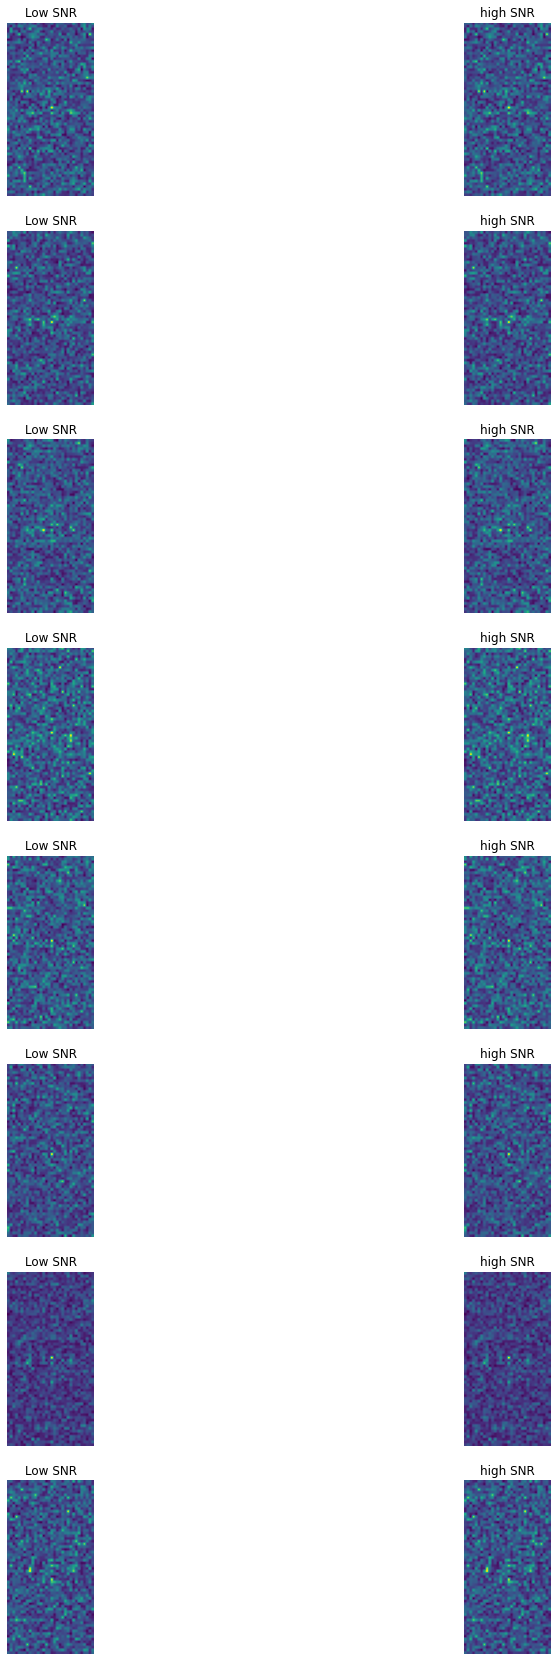

In [32]:
show_generator_output([nn_input,pred_k])

In [33]:
asd = pred_im.detach().numpy()

In [34]:
asd.shape

(12, 1, 64, 32)

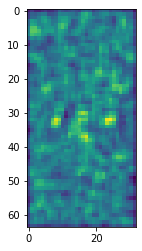

In [35]:
plt.imshow(asd[7,0,:,:])

In [ ]:
asd[7,0,:,:]